<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/splprep_thequestforgold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from numpy import arange, cos, linspace, pi, sin, random
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# make ascending spiral in 3-space
t=linspace(0,2*pi,100)

x = sin(t)
y = cos(t)
z = t

# spline parameters
s=.1 # smoothness parameter
k=2 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x,y,z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,400),tck)


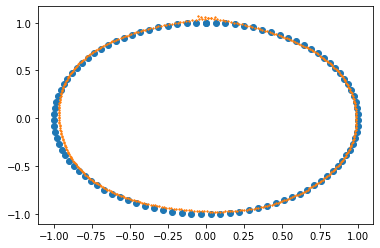

In [2]:
import matplotlib.pyplot as plt
ascatter = plt.scatter(x,y)
ascatter = plt.scatter(xnew,ynew,s=1)
plt.gca().add_artist(ascatter)


x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


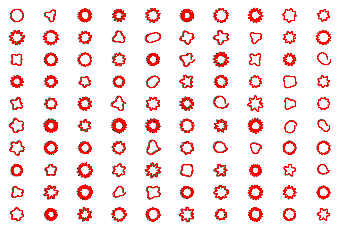

In [3]:
#add donut here
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        radii[i,:] += a
    
    assert torch.min(radii)>0
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            sample = torch.stack([sample for i in range(64)],dim = 0).cuda()
            pred = model(sample,torch.zeros(64,1000,2).cuda())#come back to this
            predres = numpoints
            X = pred[0,:,0]
            Y = pred[0,:,1]
            
            s = [.0001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            plt.plot(X.cpu(),Y.cpu(),',-',c='red', ms=.1, lw=0.1) 

    else:
        X = labels[:,0]
        Y = labels[:,1]
        s = [.0001 for x in range(numpoints)]
        c = ['red' for x in range(numpoints)]
        plt.plot(X.cpu(),Y.cpu(),',-',c='red',  ms=.1, lw=0.1) 


class DonutDataset(torch.utils.data.Dataset):
    def __init__(self, length = 10):
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0


    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        points = self.values["points"]
        points = points[idx,:]
        z = torch.zeros(numpoints,1)
        points = torch.cat([points,z], dim = 1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=1200)
        
dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',dataset, model = None)

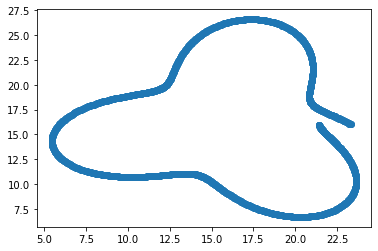

In [4]:
dataset[1][1].shape
x = dataset[1][1][:,0]
y = dataset[1][1][:,1]
ascatter = plt.scatter(x,y)
plt.gca().add_artist(ascatter)


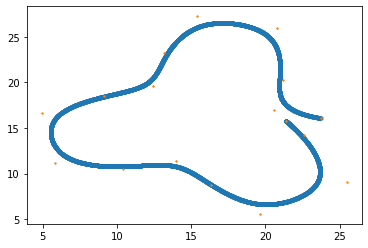

In [5]:
x = dataset[1][1][:,0]
y = dataset[1][1][:,1]
t=np.linspace(0,1,1000)
z = t

# spline parameters
s=10 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([x.cpu().numpy(),y.cpu().numpy(),z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,4000),tck)

ascatter = plt.scatter(xnew,ynew,s=10)
ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
plt.gca().add_artist(ascatter)


In [6]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length = 64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
#add model
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_dim = 1*32*32
        self.hidden_dim = self.input_dim*100
        self.output_dim = 1000*2

        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.output_dim),
            nn.Sigmoid()
        )

    def forward(self, x,points):
        x = x.squeeze()
        x = torch.flatten(x,start_dim=1)
        assert x.shape == (mini_batch,self.input_dim)
        out = self.mlp(x)
        return 32.0*out.reshape(points.shape)


In [8]:
model = MLP().cuda()


In [9]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))


In [10]:
#add training 
for i in range(40):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != 64:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    
    out = model(xin,yin[:,:,:2])
    loss = torch.mean((out-yin[:,:,:2])**2)
    loss.backward()
    optimizer.step()
  print("loss",loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 2.474613904953003
loss 1.2542067766189575
loss 0.8047835826873779
loss 0.6132994294166565
loss 0.5375865697860718
loss 0.42157331109046936
loss 0.3136407136917114
loss 0.26569923758506775
loss 0.22341348230838776
loss 0.20851020514965057
loss 0.19131556153297424
loss 0.17137791216373444
loss 0.1588401347398758
loss 0.1558702141046524
loss 0.14356090128421783
loss 0.14512479305267334
loss 0.12373770028352737
loss 0.12152794748544693
loss 0.12170929461717606
loss 0.1128881424665451
loss 0.10964649170637131
loss 0.1092500314116478
loss 0.1091151237487793
loss 0.10224384069442749
loss 0.10001325607299805
loss 0.09670615196228027
loss 0.09648119658231735
loss 0.09336405992507935
loss 0.09105409681797028
loss 0.08616432547569275
loss 0.09068820625543594
loss 0.08673438429832458
loss 0.08054706454277039
loss 0.08127275109291077
loss 0.0807371437549591
loss 0.07667136192321777
loss 0.07869130373001099
loss 0.07552538067102432
loss 0.07402794063091278
loss 0.07616958767175674


In [11]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))


In [12]:
#add training 
for i in range(40):
  for xin,yin in loader_train:
    optimizer.zero_grad()
    if xin.shape[0] != 64:
      print(xin.shape)
      continue
    xin = xin.cuda()
    yin = yin.cuda()
    
    out = model(xin,yin[:,:,:2])
    loss = torch.mean((out-yin[:,:,:2])**2)
    loss.backward()
    optimizer.step()
  print("loss",loss.item())


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


loss 0.07152244448661804
loss 0.06750457733869553
loss 0.06410288065671921
loss 0.0640777200460434
loss 0.06216355040669441
loss 0.06297297775745392
loss 0.06262816488742828
loss 0.06313510984182358
loss 0.061491020023822784
loss 0.0622178316116333
loss 0.06247129291296005
loss 0.057046130299568176
loss 0.05882594361901283
loss 0.05705590173602104
loss 0.055938683450222015
loss 0.054527781903743744
loss 0.05776986479759216
loss 0.057622868567705154
loss 0.059430502355098724
loss 0.055582672357559204
loss 0.05558197200298309
loss 0.0541747622191906
loss 0.05611778795719147
loss 0.0521477647125721
loss 0.0501638688147068
loss 0.05495552346110344
loss 0.05179636552929878
loss 0.05073968321084976
loss 0.053461864590644836
loss 0.04943132400512695
loss 0.04684353992342949
loss 0.05010281130671501
loss 0.0502336248755455
loss 0.05058945715427399
loss 0.049924883991479874
loss 0.04682227969169617
loss 0.049405328929424286
loss 0.04464641958475113
loss 0.045883242040872574
loss 0.0463520698249

note: I trained this first 40 epochs with .0001 lr
\
then 40 epochs with .00001 lr


x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


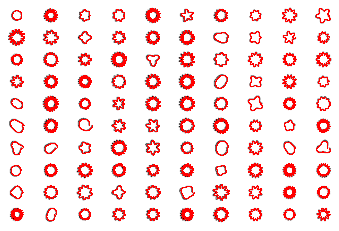

In [13]:
test_dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('testsetfit-points.png',test_dataset, model = None)

In [14]:
val_dataset = DonutDataset(length = 64)
loader_val = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=val_dataset),
    num_workers=4)

x0_y0_r_xrf_yrf torch.Size([64, 1]) torch.Size([64, 1]) torch.Size([64, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([1000, 2])


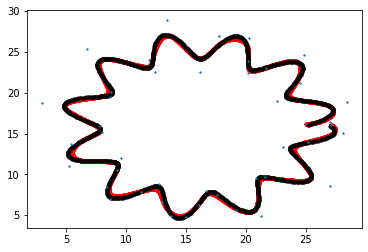

In [15]:
#display fits on validation set
xgt = None
ygt = None

out = None


for xin,yin in loader_val:
  out = model(xin.cuda(),yin[:,:,:2].cuda())
  xgt = yin[:,:,0]
  ygt = yin[:,:,1]
out = out[1,:,:]
xpred = out[:,0].detach()
ypred = out[:,1].detach()
print(out.shape)
xgt=xgt[1,:]
ygt=ygt[1,:]

t=np.linspace(0,1,1000)
z = t

# spline parameters
s=75 # smoothness parameter
k=3 # spline order
nest=-1 # estimate of number of knots needed (-1 = maximal)

# find the knot points
tck,u = splprep([xpred.cpu().numpy(),ypred.cpu().numpy(),z],s=s,k=k,nest=-1)

# evaluate spline, including interpolated points
xnew,ynew,znew = splev(linspace(0,1,4000),tck)

ascatter = plt.scatter(xnew,ynew,s=10,c='red')
ascatter = plt.scatter(xgt.cpu().numpy(),ygt.cpu().numpy(),s=10,c='black')
ascatter = plt.scatter(tck[1][0],tck[1][1],s=1)
plt.gca().add_artist(ascatter)
